In [26]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import utils
import jupyter_black

jupyter_black.load(
    lab=False,
    line_length=79,
    verbosity="DEBUG",
    target_version=black.TargetVersion.PY310,
)

In [27]:
batch = '2024_01_23_Batch_7'
pipeline = 'profiles_tcdropped_filtered_var_mad_outlier_featselect'

In [28]:
type_col = 'Metadata_node_type'
gene_col = 'Metadata_symbol'
var_col = 'Metadata_gene_allele'

In [29]:
data_dir = f"../6.downstream_analysis_snakmake/outputs/batch_profiles/{batch}"
result_dir = f"../6.downstream_analysis_snakmake/outputs/results/{batch}/{pipeline}"
sc_profiles_path = f"{data_dir}/{pipeline}.parquet"

In [30]:
sc_profiles = pd.read_parquet(sc_profiles_path)
print(sc_profiles.shape)

(1862136, 1543)


In [31]:
# Filter for variants with existing reference in the same batch 
sc_profiles, var_num_filtered = utils.filter_common_genes(sc_profiles, node_type_col=type_col, gene_col=gene_col, var_col=var_col)

This batch contains 1030 variants from 173 genes, and 338 references. The overlap between ref and var is 171.
After filtering, there are 1021 variants left.


### Visualization

In [32]:
df_result = pd.read_csv(f'{result_dir}/result.csv')
df_feat = pd.read_csv(f'{result_dir}/feat_importance.csv')

In [33]:
score_col = 'PR_AUC'
df_protein_ctrl, df_protein_var, df_non_protein_ctrl, df_non_protein_var = utils.split_result_dataframes(
    df_result, score_col=score_col)

Dropped 10 NaN rows for PR_AUC column.


In [34]:
df_protein_ctrl, df_protein_var, df_non_protein_ctrl, df_non_protein_var = utils.take_median(
    df_protein_ctrl, df_protein_var, df_non_protein_ctrl, df_non_protein_var
)

In [35]:
protein_plot_csv = utils.upsample_for_plotting(df_protein_var, df_protein_ctrl)
non_protein_plot_csv = utils.upsample_for_plotting(df_non_protein_var, df_non_protein_ctrl)

In [36]:
threshold = 95
thresh_protein, thresh_nonprotein = utils.calculate_threshold(
        df_protein_var,
        df_protein_ctrl,
        df_non_protein_var,
        df_non_protein_ctrl,
        threshold=threshold
)

Total number of ref-var pairs: 1019
Total number of control well pairs: 182
95 percentil of protein control: 0.7740492604790503
95 percentil of non-protein control: 0.9328341978578514
Number of variants passed threshold (protein): 608
Number of variants passed threshold (non-protein): 166


<Figure size 640x480 with 0 Axes>

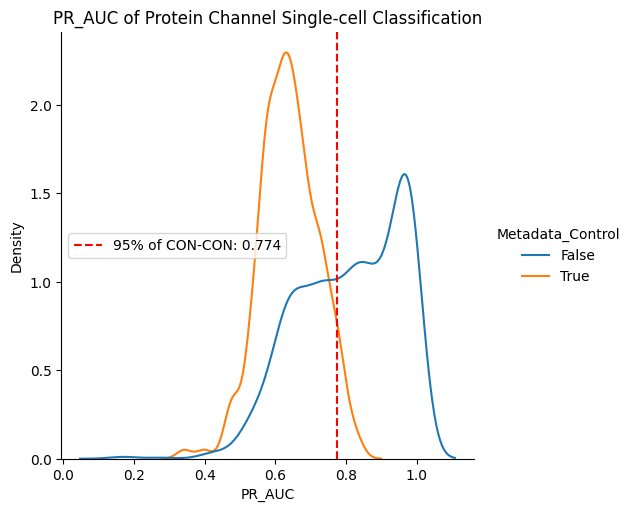

In [37]:
plt.figure()
sb.displot(
    protein_plot_csv,
    x="PR_AUC",
    hue="Metadata_Control",
    kind="kde"
)
plt.axvline(thresh_protein, color='red', linestyle='--', label=f'{threshold}% of CON-CON: {"{:.3f}".format(thresh_protein)}')
plt.legend(loc=0)

plt.title("PR_AUC of Protein Channel Single-cell Classification")
if not os.path.isdir(f'outputs/figures/{batch}/'):
    os.mkdir(f'outputs/figures/{batch}/')
plt.savefig(f'outputs/figures/{batch}/protein_classification.png', bbox_inches='tight')
plt.show()


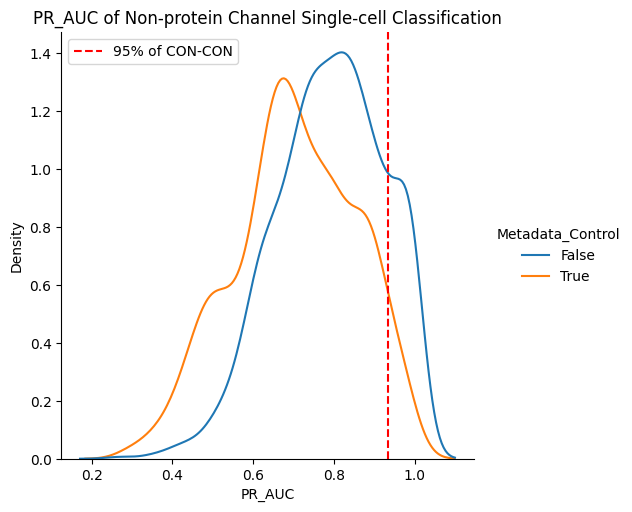

In [38]:
sb.displot(
    data=non_protein_plot_csv,
    x="PR_AUC",
    hue="Metadata_Control",
    kind='kde'
)
plt.axvline(thresh_nonprotein, color='red', linestyle='--', label='95% of CON-CON')
plt.legend(loc=0)

plt.title("PR_AUC of Non-protein Channel Single-cell Classification")
if not os.path.isdir(f'outputs/figures/{batch}/'):
    os.mkdir(f'outputs/figures/{batch}/')
plt.savefig(f'outputs/figures/{batch}/non_protein_classification.png', bbox_inches='tight')
plt.show()

In [45]:
file_path = 'outputs/data/thresholds.csv'

if not os.path.isfile(file_path):
    df_summary = pd.DataFrame()
else: 
    df_summary = pd.read_csv(file_path)

if batch in df_summary['Batch_ID'].unique():
    df_summary = df_summary.drop(np.where(df_summary['Batch_ID']==batch)[0])
    
df_batch_summary = pd.DataFrame({
    'Batch_ID': [batch],
    'num_of_var': [var_num_filtered],
    'threshold': [threshold],
    'score_thresh_protein': [thresh_protein],
    'score_thresh_non_protein':[thresh_nonprotein]
})

df_summary = pd.concat([df_summary,df_batch_summary], ignore_index=True)
df_summary.to_csv(f'outputs/data/thresholds.csv', index=False)

In [46]:
protein_passed, non_protein_passed = utils.get_positive_alleles(
    df_protein_var, df_non_protein_var, df_summary, batch, score_col
)
protein_passed['Metadata_Protein'] = True
non_protein_passed['Metadata_Protein'] = False
joint_passed = pd.concat([protein_passed, non_protein_passed], ignore_index=True)
joint_passed.to_csv(f'outputs/data/{batch}_hit.csv', index=False)